In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd '/content/gdrive/MyDrive/Nhan Dang'

/content/gdrive/MyDrive/Nhan Dang


#### Data Preprocesing

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
from sklearn.model_selection import train_test_split, KFold
import random

In [5]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else:
    print("Using CPU")

Using CUDA


In [6]:
#Load dữ liệu transform nó
def data_loader(log,data_dir, TRAIN, TEST,  image_crop_size = 227, mini_batch_size = 1 ):
    #Alexnet lấy 227x227 làm đầu vào nên cần thay đổi kích thước
    data_transforms = {
        TRAIN: transforms.Compose([
            #Cắt ảnh 227x227 
            transforms.CenterCrop(227),
            transforms.ToTensor(),
        ]),
        TEST: transforms.Compose([
            transforms.CenterCrop(227),
            transforms.ToTensor(),
        ])
    }

    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x), 
            transform=data_transforms[x]
        )
        for x in [TRAIN, TEST]
    }

    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x], batch_size=1,
            shuffle=True, num_workers=1
        )
        for x in [TRAIN, TEST]
    }
    print("Data loading complete")
    return dataloaders, image_datasets
    
def update_details(log, image_datasets):
    dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

    for x in [TRAIN, TEST]:
        print("Loaded {} images under {}".format(dataset_sizes[x], x), file = log)

    print("Classes: ", file = log)
    class_names = image_datasets[TRAIN].classes
    classification_size = len(image_datasets[TRAIN].classes)
    print(image_datasets[TRAIN].classes)
    print(classification_size)
    
    return dataset_sizes, classification_size, class_names

In [7]:
def set_up_network(net, freeze_training = True, clip_classifier = True):
    if net == 'alexnet':
        network = models.alexnet(pretrained=True)
        if freeze_training == True:
            for param in network.features.parameters():
                param.require_grad = False
        if clip_classifier:
            features = list(network.classifier.children())[:-4] # Cắt lớp cuối #[:-4]
            print("\n=========")
            print(features)
            print("\n=========")
            network.classifier = nn.Sequential(*features) 
    elif net == 'vgg16':
        network = models.vgg16(pretrained=True)
        if freeze_training == True:
            for param in network.features.parameters():
                param.require_grad = False
        if clip_classifier:
            features = list(network.classifier.children())[:-5] # Fc7->Last Layer
            print("\n=========")
            print(features)
            print("\n=========")
            network.classifier = nn.Sequential(*features)
    return network

In [8]:
#Trích xuất tính năng
def get_features(log, ipnet, file_extracted, train_batches = 10, number_of_classes = 2):
    imgfeatures = []
    imglabels = []

    selected_classes = [0, 1] #random.sample(range(0,classification_size), number_of_classes) #
    print("The selected classes are: ",selected_classes, file = log)
    for data in (dataloaders[file_extracted]):

      inputs, labels = data
      
      inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
      
      feature = ipnet(inputs)

      imgfeatures.append(feature.cpu().detach().numpy().flatten())
      imglabels.append(labels.cpu().detach().numpy())
      
      del inputs, labels, feature
      torch.cuda.empty_cache()
    return imgfeatures, imglabels

In [9]:
from sklearn.metrics import recall_score, precision_score, f1_score

In [10]:
from sklearn.metrics import classification_report, confusion_matrix  
from collections import Counter

def fit_features_to_SVM(log, class_names, features_train, labels_train, features_test, labels_test,  K=5 ):

    scores = []
    features_train = np.array(features_train)
    labels_train = np.array(labels_train)

    features_test = np.array(features_test)
    labels_test = np.array(labels_test)

    x_train = features_train
    y_train = labels_train

    x_test = features_test
    y_test = labels_test
    
    print(x_train.shape, x_test.shape)
    print(y_train.shape,y_test.shape)
    t= ['linear', 'poly', 'rbf']
    i = 0
    for kernel in t:
      model = sklearn.svm.SVC(C=1.0, kernel = kernel) #, C=1, gamma=0)
      model.fit(x_train , y_train.ravel())
      out_predict = model.predict(x_test)
      
      print("SVM with kernel: " + t[i],file=log )
      print("Confusion Matrix", file=log)
      print(confusion_matrix(y_test, out_predict), file=log)  

      #print("accuracy = ")

      pre_score = round(precision_score(y_test, out_predict),3)
      print("precision score", file=log)
      print(pre_score, file=log)  
   

      re_score = round(recall_score(y_test, out_predict),3)
      print("recall score", file=log)
      print(re_score, file=log)  
      f1_score = round(2 * pre_score * re_score /(pre_score + re_score), 3)
      print("f1 score", file=log)
      print(f1_score, file=log) 
      
      s=model.score(x_test, y_test)
      print("/",K,"The score for this classification is: ", round(s, 3), file = log)
      scores.append(s)
      print("-"*30, file=log)

      i = i+1
    return np.mean(scores), np.std(scores)

### Training

In [11]:
data_dir = '/content/gdrive/MyDrive/Nhan Dang/Project_1/Dog_Cat'
TRAIN = 'train'
TEST = 'test'
ImageDirectory = [data_dir]

In [12]:
#Using alexnet
alex_net_nc = set_up_network('alexnet', freeze_training = True)
if use_gpu:
    alex_net_nc.cuda() #.cuda() will move everything to the GPU side  


[Dropout(p=0.5, inplace=False), Linear(in_features=9216, out_features=4096, bias=True), ReLU(inplace=True)]



In [13]:
#Using VGG16
vgg16_nc = set_up_network('vgg16', freeze_training = True)
if use_gpu:
    vgg16_nc.cuda() #.cuda() will move everything to the GPU side 


[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True)]



In [15]:
for i, data_dir in enumerate(ImageDirectory):
    file = open("VGG16_Task_Dog_Cat.txt", "w")

    # Get Data
    dataloaders, image_datasets = data_loader(file,data_dir, TRAIN, TEST, image_crop_size = 227, mini_batch_size = 1 )
    dataset_sizes, classification_size, class_names = update_details(file, image_datasets) #Lấy dữ liệu, phân loại ảnh, chia train, test
    
    # Update train_batch_size = 302
    train_batch_size = dataset_sizes[TRAIN]
    test_batch_size = dataset_sizes[TEST]
#     train_batch_size = 50
    class_size = classification_size

    imgfeatures_train, imglabels_train = get_features(file, vgg16_nc,'train' ,train_batch_size, number_of_classes = class_size) #Rút trích đặc trưng cho tập train
    imgfeatures_test, imglabels_test = get_features(file, vgg16_nc,'test' ,test_batch_size, number_of_classes = class_size) #Rút trích đặc trưng cho tập test
    
    mean_accuracy, sd = fit_features_to_SVM(file, 
                                        class_names, 
                                        imgfeatures_train, #Cho vào SVM
                                        imglabels_train, 
                                        imgfeatures_test, 
                                        imglabels_test, 
                                        K=5)

    file.close()
    # print('dataloaders = ', dataloaders)
    # print('image_datasets = ', image_datasets)
    # print('dataset_sizes = ', dataset_sizes)
    # print('classification_size = ', classification_size)
    # print('class_names = ', class_names)
    # print('imgfeatures_alexn', len(imgfeatures_alexn))
    # print('imglabels_alexn', len(imglabels_alexn))
    # del dataloaders, image_datasets, imgfeatures_alexn, imglabels_alexn
   

Data loading complete
['Cat', 'Dog']
2
(302, 4096) (100, 4096)
(302, 1) (100, 1)


# **Confusion Matrix**

# ***Alexnet Model***

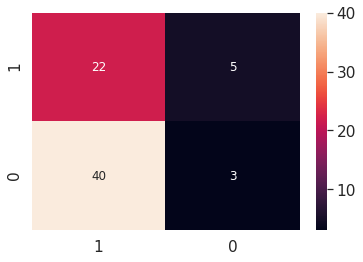

In [ ]:
#SVM with kernel Linear (Data Dog_Cat)
array = [[22,5],
         [40, 3]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

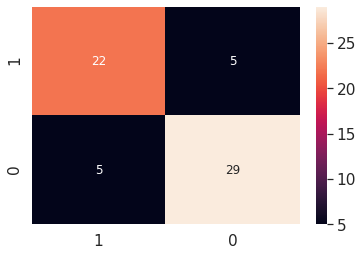

In [ ]:
#SVM with kernel Poly (Data Dog_Cat)
array = [[22,5],
         [5, 29]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

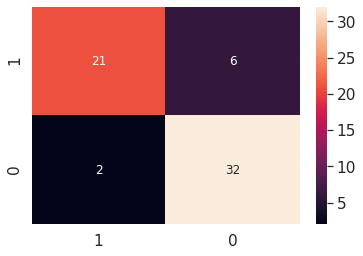

In [ ]:
#SVM with kernel rbf (Data Dog_Cat)
array = [[21,6],
         [2, 32]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

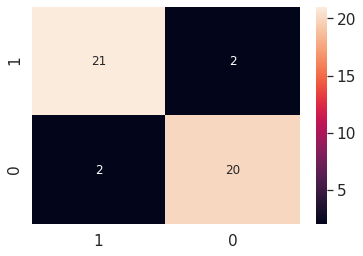

In [ ]:
#SVM with kernel Linear (Data Fruit)
array = [[21,2],
         [2,20]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

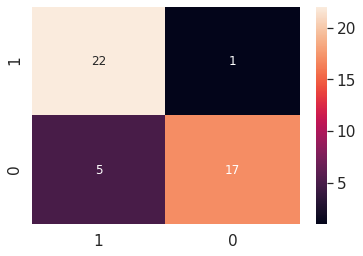

In [ ]:
#SVM with kernel Poly (Data Fruit)
array = [[22,1],
         [5,17]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

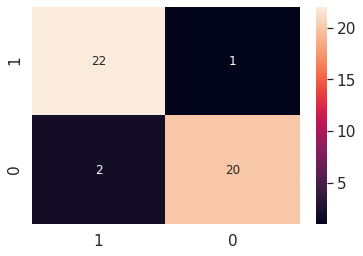

In [ ]:
#SVM with kernel rbf (Data Fruit)
array = [[22,1],
         [2,20]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

# ***VGG16 Model***

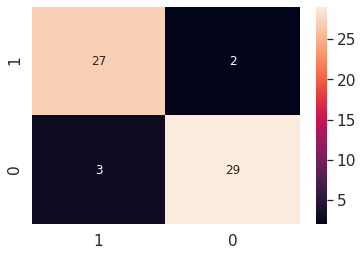

In [ ]:
#SVM with kernel Linear (Data Dog_Cat)
array = [[27,2],
         [3, 29]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

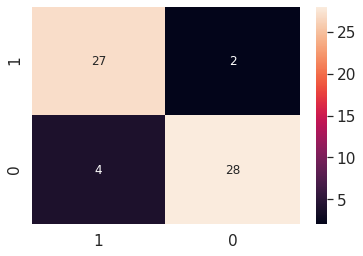

In [ ]:
#SVM with kernel Poly (Data Dog_Cat)
array = [[27,2],
         [4, 28]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

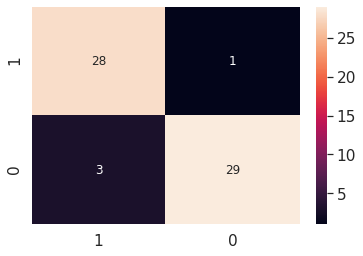

In [ ]:
#SVM with kernel rbf (Data Dog_Cat)
array = [[28,1],
         [3, 29]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

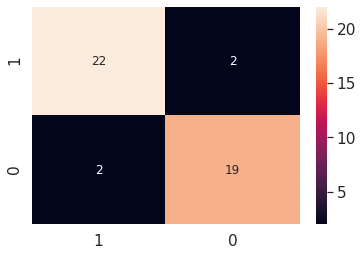

In [ ]:
#SVM with kernel Linear (Data Fruit)
array = [[22,2],
         [2,19]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

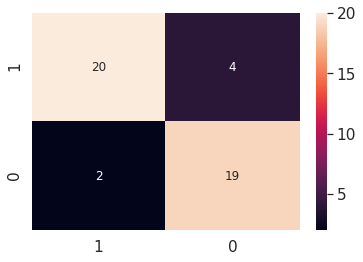

In [ ]:
#SVM with kernel Poly (Data Fruit)
array = [[20,4],
         [2,19]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

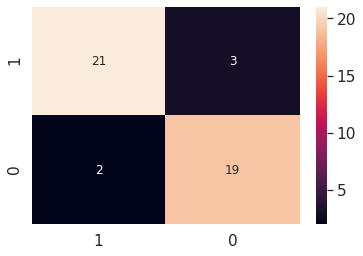

In [ ]:
#SVM with kernel rbf (Data Fruit)
array = [[21,3],
         [2,19]]
df_cm = pd.DataFrame(array, index = [i for i in [1, 0]],
                  columns = [i for i in [1, 0]])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

# **Predict**